In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [22]:
# sandbox for playing with upsampling (or whatever else comes up)
# demonstrates the interpolate,linear method does the intended infill
# note the need to use sort_index after adding an additional entry


MAX_READING = 2000
PERIODS = 200
# linear data
#df = pd.DataFrame(data=list(range(1,MAX_READING*.5,100)), index=pd.date_range('2017-07-01', periods=3, freq='D'), columns=['reading'])

# random data
df = pd.DataFrame(data=np.random.uniform(1,MAX_READING,PERIODS), index=pd.date_range('2017-07-01', periods=PERIODS, freq='3H'), columns=['reading'])

# make some lower and higher days
for i in range(3):
    j = np.random.randint(1,8)
    df['reading'].loc[f'2017-07-0{j}'] = df['reading'].loc[f'2017-07-0{j}'] * .4
                  
# add a specific data point and then resort
for i in range(24):
    df.loc[datetime.strptime(f'2017-07-03 {i}:00:00', '%Y-%m-%d %H:%M:%S'),'reading'] = np.random.uniform(MAX_READING-100,MAX_READING,1)
df = df.sort_index()

# interpolate to fill in any missing data
df_resampled = df.resample('H').interpolate(method='linear')
#df_resampled

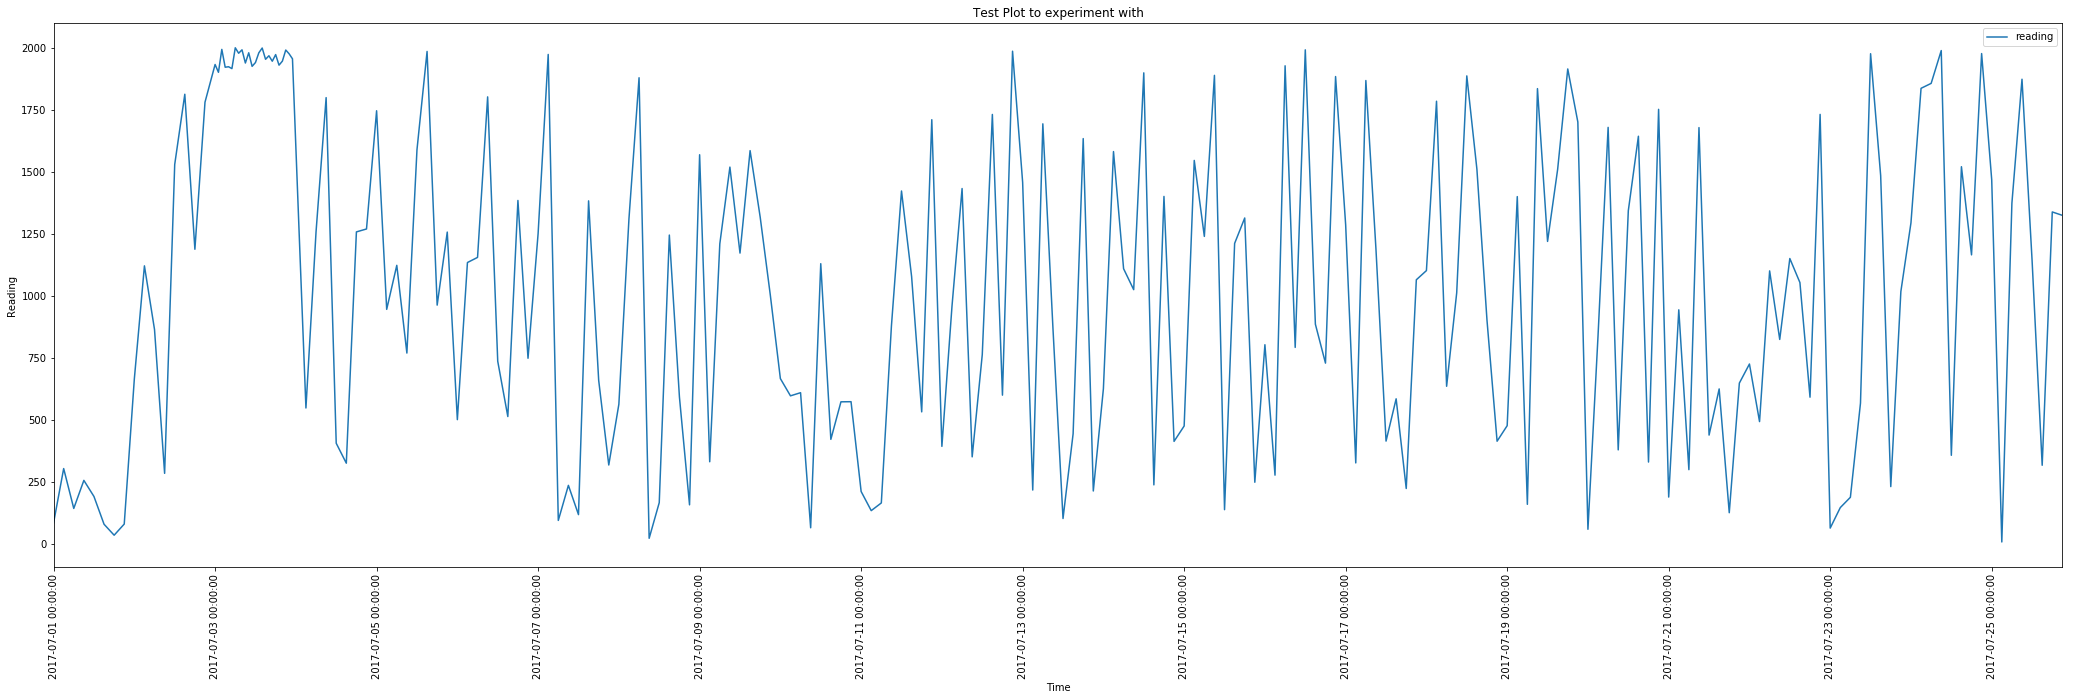

In [23]:
# plot some data from the sandbox


# to do scatter plot based on datetime index
df_resampled['time_as_int']=df_resampled.index.astype(np.int64) # to do scatter datetimes must be converted to ints
df_resampled['time_as_str']=df_resampled.index.astype('str') # to get tick labels, convert to strings
#df_resampled['ticks']=df_resampled['time_as_str'].apply(lambda x: x[-8:]) #slice you would choose for tick labels
df_resampled['ticks']=df_resampled['time_as_str']
#df_resampled.plot('time_as_int', 'reading', kind='scatter')

# line plot
df_resampled.plot('time_as_int','reading')
fig = plt.gcf()
fig.set_size_inches(36, 10)

# labels
plt.xlabel('Time');
plt.ylabel('Reading')
plt.title('Test Plot to experiment with')
plt.xticks(df_resampled['time_as_int'].iloc[::48],df_resampled['ticks'].iloc[::48],rotation='vertical')
plt.show(); # ; added to prevent Jupyter from duplicating plot which occurs when plot is last referenced line

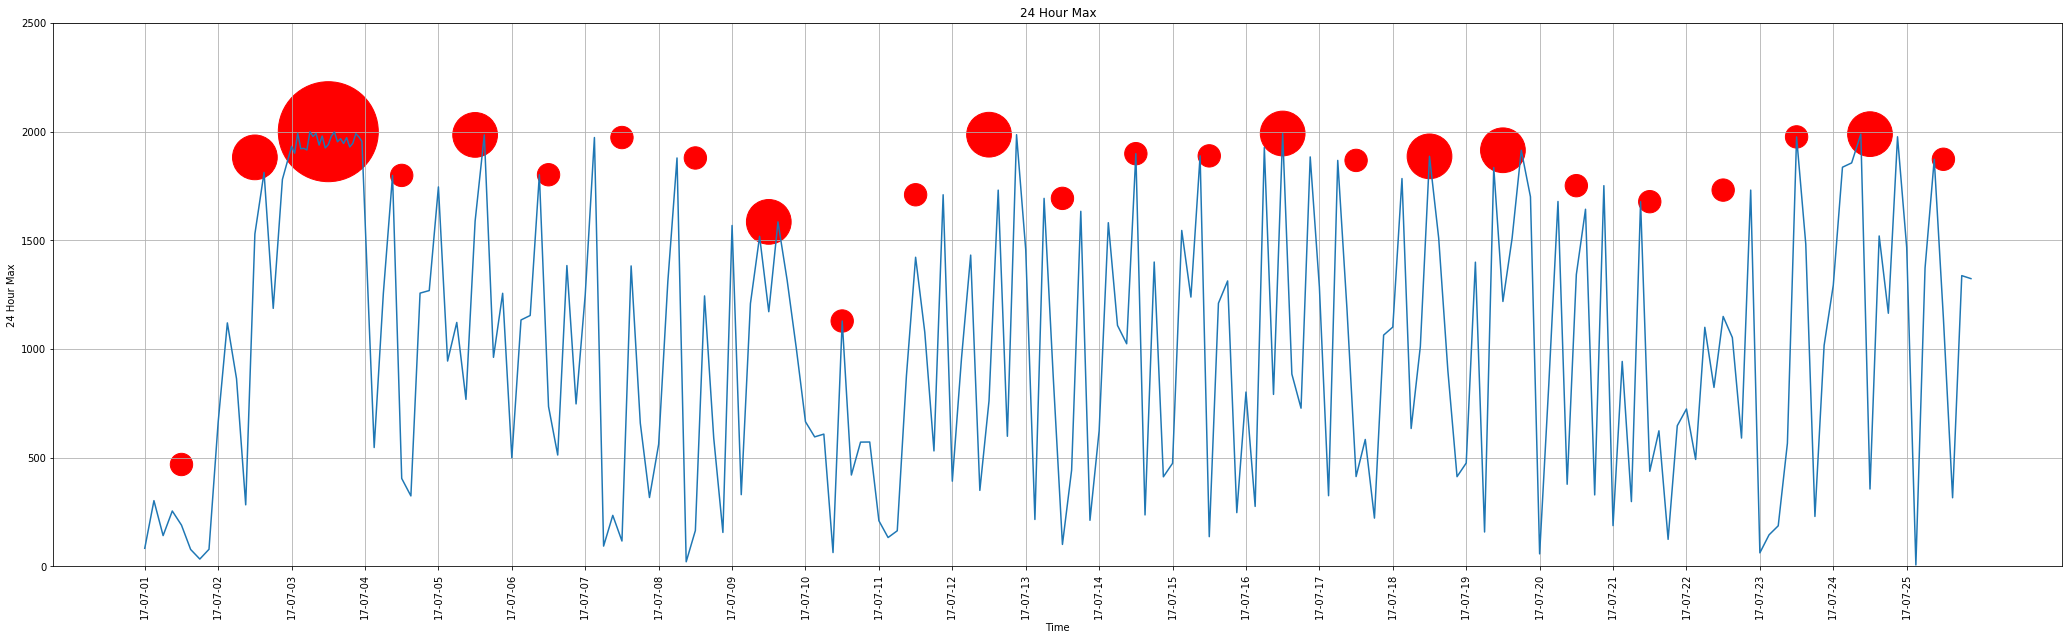

In [38]:
# create day summary from interpolated data
def point_size(x, min, max): # set the point size based on the sum totals and existing sums
    diff = max - min
    group1 = min + .25 * diff
    group2 = group1 + .25 * diff
    group3 = group2 + .25 * diff
    group4 = group3 + .20 * diff
    if x > group4: return 10000
    elif x > group3: return 6000
    elif x > group2: return 2000
    else: return 500

DAYINMS = 8.64*10**13
freq = 24
hourfreq = str(freq)+'H'
df_summary = df_resampled.resample(hourfreq).max()
df_summary = pd.DataFrame(df_summary['reading'])
df_summary.columns = ['reading_max']
temp_sum = df_resampled.resample(hourfreq).sum()
#print(temp_sum.describe())
#temp_sum.plot(temp_sum.index,'reading')
#plt.show()
sum_min = temp_sum['reading'].min()
sum_max = temp_sum['reading'].max()
df_summary['point_size']=temp_sum['reading'].apply(point_size, args=(sum_min,sum_max,))

df_summary['time_as_int']=df_summary.index.astype(np.int64) # to do scatter datetimes must be converted to ints
df_summary['shifted_time']=df_summary['time_as_int']+(.5*DAYINMS) #half day shift to center dot on day
df_summary['time_as_str']=df_summary.index.astype('str') # to get tick labels, convert to strings
df_summary['ticks']=df_summary['time_as_str'].apply(lambda x: x[-8:]) #slice you would choose for tick labels
#df_summary.plot('time_as_int', 'reading_max', kind='scatter', s=df_summary['reading_sum'])
#df_summary.plot('time_as_int', 'reading_max', kind='line')
plt.scatter(df_summary['shifted_time'],df_summary['reading_max'],s=df_summary['point_size'], c='r')
plt.plot(df_resampled['time_as_int'], df_resampled['reading'])
fig2 = plt.gcf()
fig2.set_size_inches(36, 10)
#plt.plot(df_summary['time_as_int'],df_summary['reading_max'])
plt.xticks(df_summary['time_as_int'],df_summary['ticks'],rotation='vertical')
plt.xlabel('Time');
plt.ylabel(str(freq) + ' Hour Max')
#plt.ylim(df_summary['reading_max'].min() - 100,MAX_READING + 100)
plt.ylim(0,MAX_READING + 500)
#plt.xlim(df_summary['time_as_int'][0],df_summary['time_as_int'][-1]+DAYINMS)
plt.title(str(freq) + ' Hour Max')
plt.grid()

'''plt.figure()
#plt.subplot()
df_resampled.plot(subplots=True)
plt.xlabel('Time');
plt.ylabel('Reading')
plt.title('Readings vs Time')
plt.grid()
'''
plt.show(); # ; added to prevent Jupyter from duplicating plot which occurs when plot is last referenced line